In [200]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
nbbo = pd.read_csv('/Users/jeremyobadia/Desktop/MFin/MIT Fall Term/Financial Markets/Assignments/Assignment 4/equity transaction cost_data/nbbo_01oct2010.csv')
trades = pd.read_csv('/Users/jeremyobadia/Desktop/MFin/MIT Fall Term/Financial Markets/Assignments/Assignment 4/equity transaction cost_data/trades_01oct2010.csv')


## Formating the Data ##

#### We convert the time to seconds ####

In [3]:
nbbo['time']=nbbo['time']/10**3
trades['Time']=trades['Time']/10**9

In [4]:
9.5*3600

34200.0

In [5]:
16*3600

57600

In [6]:
nbbo.head()

,symbol,time,bid,ask
0,AA,14403.252,0.00,12.24
1,AA,14403.256,10.55,12.24
2,AA,14403.262,11.79,12.24
3,AA,14408.843,12.12,12.24
4,AA,14408.845,11.79,12.24


In [8]:
l=[]
for i in range(0,len(nbbo)):
    if nbbo['time'][i] < 9.5*3600:
        l.append(i)
    if nbbo['time'][i]>16*3600:
        l.append(i)


In [37]:

nbbo_trimmed =nbbo.drop(l)
nbbo_trimmed= nbbo_trimmed.set_index('time')

In [38]:
nbbo_trimmed.head()

,symbol,bid,ask
time,,,
34204.638,AA,12.26,12.28
34210.670,AA,12.26,12.29
34214.310,AA,12.27,12.29
34214.372,AA,12.28,12.29
34217.644,AA,12.27,12.29


In [12]:
d=[]
for i in range(0,len(trades)):
    if trades['Time'][i] < 9.5*3600:
        d.append(i)
    if trades['Time'][i]>16*3600:
        d.append(i)

In [218]:
trades_trimmed = trades.drop(d)
trades_trimmed = trades_trimmed.set_index('Time')
trades_trimmed.head()

,Symbol,Shares,BuySell,Price
Time,,,,
34200.226311,AA,145,B,12.24
34200.320291,AA,750,B,12.29
34210.669583,AA,100,B,12.28
34214.319373,AA,289,B,12.29
34214.319373,AA,211,B,12.29


In [15]:
set_trades = set(trades_trimmed['Symbol'])
securities = list(set_trades)
securities.sort()


## Merging and sorting ##

In [43]:
df_sec= pd.DataFrame()
for symbol in securities:
    df= pd.concat([nbbo_trimmed.loc[nbbo_trimmed['symbol']==symbol], trades_trimmed.loc[trades_trimmed['Symbol']==symbol]], sort = False)

    df_l= df.sort_index()

    df_l.drop(['Symbol'], axis =1)

    df_l['symbol'] =df_l['symbol'].fillna(value = symbol)
    df_l['bid'] = df_l['bid'].fillna(method='ffill')
    df_l['ask'] = df_l['ask'].fillna(method='ffill')
    #print(df_l) optional print statement
    df_sec = df_sec.append(df_l)


In [210]:
df_sec = df_sec.fillna(0)

In [212]:
df_sec.tail(10)

,symbol,bid,ask,Symbol,Shares,BuySell,Price
57595.099585,SWN,33.46,33.47,SWN,3.0,B,33.47
57597.241819,SWN,33.46,33.47,SWN,100.0,S,33.46
57597.831231,SWN,33.46,33.47,SWN,6.0,S,33.46
57598.023433,SWN,33.46,33.47,SWN,34.0,B,33.47
57599.027753,SWN,33.46,33.47,SWN,100.0,S,33.46
57599.087433,SWN,33.46,33.47,SWN,94.0,S,33.46
57599.106000,SWN,33.45,33.47,0,0.0,0,0.00
57599.335906,SWN,33.45,33.47,SWN,100.0,S,33.45
57599.537000,SWN,33.46,33.47,0,0.0,0,0.00
57599.562000,SWN,33.45,33.46,0,0.0,0,0.00


## Value-weighted transaction costs averages ##

## May take some time to run ##

In [213]:
metrics = ['Buy Weights', 'Buy', 'Average Buy Transaction Cost in %', 'Sell Weights', 'Sell', 'Average Sell Transaction Cost in %']

results = pd.DataFrame(index = metrics, columns =securities )

for symbols in securities:
    buy=[]
    buy_weights= []
    sell=[]
    sell_weights=[]
    
    sec = df_sec.loc[df_sec['symbol'] == symbols].reset_index(drop=True)
    sec_buy = sec[sec['BuySell']=='B'].reset_index(drop=True)
    sec_sell = sec[sec['BuySell']=='S'].reset_index(drop=True)
    
    for i in range(0, len(sec_buy)):
        if sec_buy['bid'][i]> 0:
            a= sec_buy['bid'][i]
            a = a.item()
            b=sec_buy['ask'][i]
            b = b.item()
            c = [a,b]
            mean_buy = np.mean(c)
            buy.append((sec_buy['Price'][i]-mean_buy)/mean_buy*sec_buy['Shares'][i])
            buy_weights.append(sec_buy['Shares'][i])
            
    
    for y in range(0, len(sec_sell)):
        if sec_sell['bid'][y]> 0:
            a= sec_sell['bid'][y]
            a = a.item()
            b=sec_sell['ask'][y]
            b = b.item()
            c = [a,b]
            mean_sell = np.mean(c)
            sell.append((mean_sell-sec_sell['Price'][y])/mean_sell*sec_sell['Shares'][y])
            sell_weights.append(sec_sell['Shares'][y])
    
    results[symbols]['Buy Weights'] = buy_weights
    results[symbols]['Sell Weights'] = sell_weights
    results[symbols]['Buy'] = buy
    results[symbols]['Sell'] = sell
    results[symbols]['Average Buy Transaction Cost in %']= np.round(sum(buy)/sum(buy_weights)*100, decimals=3)
    results[symbols]['Average Sell Transaction Cost in %']= np.round(sum(sell)/sum(sell_weights)*100, decimals=3)

In [214]:
results

,AA,AAPL,ABD,ADBE,AGN,AINV,AMAT,AMED,AMGN,AMZN,...,PTP,RIGL,ROC,ROCK,ROG,RVI,SF,SFG,SJW,SWN
Buy Weights,"[100.0, 211.0, 289.0, 500.0, 100.0, 100.0, 100...","[100.0, 300.0, 100.0, 100.0, 100.0, 100.0, 20....","[7.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0...","[100.0, 100.0, 32.0, 100.0, 50.0, 18.0, 18.0, ...","[25.0, 4.0, 100.0, 33.0, 100.0, 10.0, 90.0, 20...","[45.0, 100.0, 200.0, 200.0, 100.0, 100.0, 100....","[100.0, 100.0, 57.0, 200.0, 43.0, 200.0, 900.0...","[200.0, 100.0, 100.0, 100.0, 1.0, 4.0, 4.0, 96...","[7.0, 7.0, 93.0, 107.0, 93.0, 200.0, 100.0, 81...","[100.0, 100.0, 300.0, 100.0, 100.0, 100.0, 200...",...,"[100.0, 100.0, 100.0, 100.0, 100.0, 19.0, 100....","[100.0, 100.0, 200.0, 100.0, 100.0, 100.0, 100...","[276.0, 100.0, 100.0, 5.0, 95.0, 5.0, 100.0, 8...","[18.0, 72.0, 28.0, 28.0, 100.0, 79.0, 200.0, 3...","[40.0, 100.0, 100.0, 37.0, 4.0, 1.0, 1.0, 100....","[100.0, 200.0, 32.0, 10.0, 80.0, 10.0, 100.0, ...","[100.0, 100.0, 100.0, 65.0, 35.0, 100.0, 100.0...","[100.0, 100.0, 1.0, 199.0, 100.0, 100.0, 100.0...","[8.0, 58.0, 1.0, 99.0, 1.0, 100.0, 53.0, 100.0...","[200.0, 300.0, 1300.0, 400.0, 21.0, 2.0, 79.0,..."
Buy,"[0.08149959250203576, 0.17182410423452404, 0.2...","[0.04890658841612043, 0.1100263714001483, 0.04...","[0.01802575107296206, 0.08628127696289721, -0....","[0.03800836183959715, 0.03800836183959715, 0.0...","[0.0168425780372842, 0.001500487658488497, 0.0...","[0.13056092843326608, 0.19323671497582412, 0.5...","[0.21285653469560306, 0.1700680272108807, 0.09...","[-0.20916126333404833, -0.10458063166702417, -...","[0.0, 0.0012598992080631042, 0.016738660907124...","[0.03186743148502956, 0.03186743148502956, 0.0...",...,"[0.39342744735015434, 0.1967820349577517, 0.18...","[0.05991611743559954, 0.05991611743559954, 0.1...","[-0.347279018559288, 0.2214489085732372, 0.110...","[0.04942339373970416, 0.07991120976692394, 0.0...","[0.13238770685578802, 0.36191974822974665, 0.2...","[0.5514705882352824, 0.0, 0.03004694835680687,...","[0.07465074117520867, 0.10702054794521461, 0.1...","[0.14388489208633018, 0.0649772579597104, 0.00...","[0.022544283413847576, 0.10655235762400052, -0...","[0.1768867924528369, 0.26533018867925534, 1.14..."
Average Buy Transaction Cost in %,0.034,0.004,0.079,0.014,0.01,0.021,0.03,0.013,0.004,0.006,...,0.018,0.032,0.027,0.065,0.108,0.061,0.035,0.025,0.054,0.016
Sell Weights,"[100.0, 100.0, 100.0, 200.0, 100.0, 100.0, 100...","[300.0, 100.0, 200.0, 100.0, 100.0, 100.0, 30....","[100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 400...","[200.0, 100.0, 69.0, 120.0, 219.0, 60.0, 81.0,...","[2.0, 35.0, 100.0, 24.0, 100.0, 6.0, 15.0, 100...","[2.0, 8.0, 2.0, 2.0, 98.0, 64.0, 191.0, 100.0,...","[100.0, 100.0, 95.0, 100.0, 100.0, 100.0, 100....","[1.0, 100.0, 100.0, 100.0, 15.0, 100.0, 35.0, ...","[100.0, 100.0, 100.0, 100.0, 19.0, 1.0, 100.0,...","[100.0, 20.0, 80.0, 35.0, 65.0, 6.0, 50.0, 28....",...,"[25.0, 100.0, 30.0, 70.0, 30.0, 170.0, 100.0, ...","[18.0, 1.0, 20.0, 100.0, 100.0, 6.0, 100.0, 6....","[100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100...","[2.0, 10.0, 100.0, 90.0, 100.0, 100.0, 70.0, 2...","[22.0, 100.0, 200.0, 100.0, 51.0, 200.0, 100.0...","[100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100...","[100.0, 1.0, 96.0, 100.0, 81.0, 16.0, 3.0, 19....","[18.0, 12.0, 12.0, 100.0, 50.0, 50.0, 100.0, 1...","[100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100...","[15.0, 70.0, 30.0, 100.0, 70.0, 40.0, 100.0, 4..."
Sell,"[0.04070004070004706, 0.04070004070004706, 0.0...","[-0.020959966464034595, 0.0, 0.010479434110548...","[0.1721170395869307, 0.1721170395869307, 0.0, ...","[-0.1902225603956521, -0.09511128019782605, 0....","[-0.000896995066527168, 0.08113362745831955, 0...","[3.4325736027057975e-16, -0.003866602223295509...","[-0.3407155025553742, -0.04257130693911456, 0....","[0.0, 0.020995171110640375, 0.0209951711106403...","[0.035990642432973056, 0.035990642432973056, 0...","[-0.025493945188030893, -0.005736320469105571,...",...,"[-0.06652782598634437, 0.13879250520470776, 0....","[3.797437

## Formatting of Market Cap DataFrame ##

In [196]:
mktcap = pd.read_csv('/Users/jeremyobadia/Desktop/MFin/MIT Fall Term/Financial Markets/Assignments/Assignment 4/equity transaction cost_data/mktcap.csv')
mktcap['log_mktcap'] = np.log(mktcap['mktcap'])
mktcap['Buy_Transaction_Cost']=results[2:3].values[0]
mktcap['Sell_Transaction_Cost'] = results[5:].values[0]
mktcap = mktcap.set_index('symbol')
mktcap.head()

,mktcap,log_mktcap,Buy_Transaction_Cost,Sell_Transaction_Cost
symbol,,,,
AA,1.236690e+10,23.238290,0.0336502,0.0312541
AAPL,2.600000e+11,26.283947,0.00401789,0.00435245
ABD,3.155255e+08,19.569750,0.0793679,0.0959708
ADBE,1.366748e+10,23.338285,0.0139032,0.0127349
AGN,2.045877e+10,23.741678,0.0100481,0.0103801


## Regressions ##

In [197]:
Y_buy= mktcap['Buy_Transaction_Cost'].astype(float)
X_buy = mktcap['log_mktcap'].astype(float)
X_buy = sm.add_constant(X_buy)
model_buy = sm.OLS(Y_buy, X_buy).fit(cov_type='HC1')
model_buy.summary()

/Applications/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     Buy_Transaction_Cost   R-squared:                       0.342
Model:                              OLS   Adj. R-squared:                  0.336
Method:                   Least Squares   F-statistic:                     59.29
Date:                  Mon, 30 Sep 2019   Prob (F-statistic):           5.18e-12
Time:                          17:13:50   Log-Likelihood:                 271.45
No. Observations:                   117   AIC:                            -538.9
Df Residuals:                       115   BIC:                            -533.4
Df Model:                             1                                         
Covariance Type:                    HC1                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2305      0.027      8.447      0.000       0.177       0.284
log_mktcap    -0.0091      0.001     -7.700      0.000      -0.011      -0.007
==============================================================================
Omnibus:                       61.269   Durbin-Watson:                   1.779
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              233.768
Skew:                           1.861   Prob(JB):                     1.73e-51
Kurtosis:                       8.839   Cond. No.                         256.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

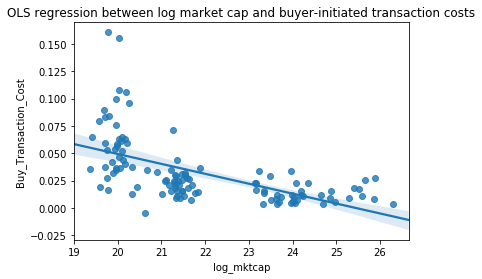

In [215]:
sns.regplot(x='log_mktcap', y='Buy_Transaction_Cost', data=mktcap)
plt.title('OLS regression between log market cap and buyer-initiated transaction costs')
plt.show()

In [198]:
Y_sell= mktcap['Sell_Transaction_Cost'].astype(float)
X_sell = mktcap['log_mktcap'].astype(float)
X_sell = sm.add_constant(X_sell)
model_sell = sm.OLS(Y_sell, X_sell).fit(cov_type='HC1')

model_sell.summary()


/Applications/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     Sell_Transaction_Cost   R-squared:                       0.358
Model:                               OLS   Adj. R-squared:                  0.352
Method:                    Least Squares   F-statistic:                     64.80
Date:                   Mon, 30 Sep 2019   Prob (F-statistic):           8.44e-13
Time:                           17:13:56   Log-Likelihood:                 270.12
No. Observations:                    117   AIC:                            -536.2
Df Residuals:                        115   BIC:                            -530.7
Df Model:                              1                                         
Covariance Type:                     HC1                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2409      0.027      8.818      0.000       0.187       0.294
log_mktcap    -0.0095      0.001     -8.050      0.000      -0.012      -0.007
==============================================================================
Omnibus:                       46.676   Durbin-Watson:                   1.795
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              126.977
Skew:                           1.504   Prob(JB):                     2.68e-28
Kurtosis:                       7.123   Cond. No.                         256.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

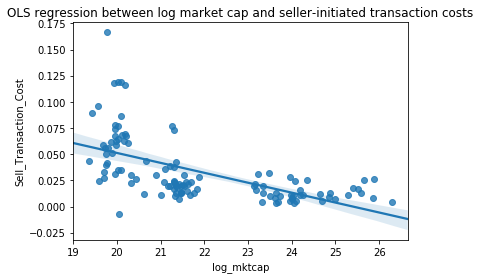

In [216]:
sns.regplot(x='log_mktcap', y='Sell_Transaction_Cost', data=mktcap)
plt.title('OLS regression between log market cap and seller-initiated transaction costs')
plt.show()